# 3.1 추론 기반 기법과 신경망

## 3.1.3 신경망에서의 단어 처리

In [4]:
import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
h = np.matmul(c, W)
print(h)

[[ 1.18630185 -0.08275107 -0.05778151]]


In [5]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.80280958  0.49001355 -0.18944556]]


# 3.2 단순한 word2vec

## 3.2.1 CBOW 모델의 추론 처리

In [6]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.rand(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s) 

[[0.19363031 0.44165698 0.73502428 0.82554258 0.51957858 0.22840059
  0.71847365]]


# 3.3 학습 데이터 준비

## 3.3.1 맥락과 타깃

In [7]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [8]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [9]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


## 3.3.2 원핫 표현으로 변환

원핫 표현으로의 변환

In [10]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [11]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# 3.4 CBOW 모델 구현

In [ ]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer =- SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
    
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [ ]:
def remove_duplicate(params, grads):
    '''
    매개변수 배열 중 중복되는 가중치를 하나로 모아
    그 가중치에 대응하는 기울기를 더한다.
    '''
    params, grads = params[:], grads[:]  # copy list

    while True:
        find_flg = False
        L = len(params)

        for i in range(0, L - 1):
            for j in range(i + 1, L):
                # 가중치 공유 시
                if params[i] is params[j]:
                    grads[i] += grads[j]  # 경사를 더함
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)
                # 가중치를 전치행렬로 공유하는 경우(weight tying)
                elif params[i].ndim == 2 and params[j].ndim == 2 and \
                     params[i].T.shape == params[j].shape and np.all(params[i].T == params[j]):
                    grads[i] += grads[j].T
                    find_flg = True
                    params.pop(j)
                    grads.pop(j)

                if find_flg: break
            if find_flg: break

        if not find_flg: break

    return params, grads

## 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 404 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 405 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 406 |  반복 1 / 2 | 시간 0[s] | 손실 0.86
| 에폭 407 |  반복 1 / 2 | 시간 0[s] | 손실 0.59
| 에폭 408 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 409 |  반복 1 / 2 | 시간 0[s] | 손실 0.80
| 에폭 410 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 411 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 412 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 413 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 414 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 415 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 416 |  반복 1 / 2 | 시간 0[s] | 손실 0.54
| 에폭 417 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 418 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 419 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 420 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 421 |  반복 1 / 2 | 시간 0[s] | 손실 0.83
| 에폭 422 |  반복 1 / 2 | 시간 0[s] | 손실 0.79
| 에폭 423 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 424 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 425 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 426 |  반복 1 / 2 | 시간 0[s] | 손실 0.73
| 에폭 427 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 428 |  반복 1

| 에폭 821 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 822 |  반복 1 / 2 | 시간 0[s] | 손실 0.28
| 에폭 823 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 824 |  반복 1 / 2 | 시간 0[s] | 손실 0.19
| 에폭 825 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 826 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 827 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 828 |  반복 1 / 2 | 시간 0[s] | 손실 0.36
| 에폭 829 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 830 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 831 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 832 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 833 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 834 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 835 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 836 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 837 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 838 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 839 |  반복 1 / 2 | 시간 0[s] | 손실 0.27
| 에폭 840 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 841 |  반복 1 / 2 | 시간 0[s] | 손실 0.38
| 에폭 842 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 843 |  반복 1 / 2 | 시간 0[s] | 손실 0.26
| 에폭 844 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 845 |  반복 1

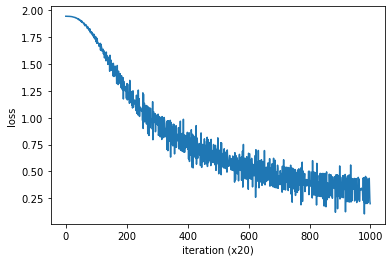

In [15]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
from common.trainer import Trainer
from common.optimizer import Adam
from ch03.simple_cbow import SimpleCBOW
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [16]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.96249646 -0.96506    -0.9238251   1.685398   -0.9509637 ]
say [1.140355   1.1552193  0.04356381 1.2152562  1.1311442 ]
goodbye [-1.0647339 -1.0327902 -0.9811917 -0.5848243 -1.0662838]
and [0.80858517 0.75630385 1.8961017  1.2090446  0.9532468 ]
i [-1.0341116 -1.0040611 -0.956608  -0.5786802 -1.0499307]
hello [-0.9891179 -0.9725827 -0.9140799  1.6740813 -0.9686472]
. [ 1.1663282  1.1842409 -1.643168   0.7456128  1.026521 ]


Skip-gram 구현

In [ ]:
import sys
sys.path.append('C:\deep-learning-from-scratch-2-master')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleSkipGram:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        self.in_layer = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer1 = SoftmaxWithLoss()
        self.loss_layer2 = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)
        s = self.out_layer.forward(h)
        l1 = self.loss_layer1.forward(s, contexts[:, 0])
        l2 = self.loss_layer2.forward(s, contexts[:, 1])
        loss = l1 + l2
        return loss

    def backward(self, dout=1):
        dl1 = self.loss_layer1.backward(dout)
        dl2 = self.loss_layer2.backward(dout)
        ds = dl1 + dl2
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        return None